In [6]:
import numpy as np
import keras as kr
import cv2 as cv

(x_train_initial, y_train_initial), (x_test_initial, y_test_initial) = kr.datasets.mnist.load_data()
x_train = np.empty((60000, 784))
x_test = np.empty((10000, 784))

#Flattening examples (28,28) to (1,784)
for i in range(60000):
    for j in range(28):
        for k in range(28):
            x_train[i][j*28+k] = (x_train_initial[i][j][k])/255
for i in range(10000):
    for j in range(28):
        for k in range(28):
            x_test[i][j*28+k] = (x_test_initial[i][j][k])/255



In [7]:
y_train = np.empty((10,60000))
y_test = np.empty((10,10000))
for j in range(60000):
    for i in range(10):
        y_train[i][j] = 1 if i == y_train_initial[j] else 0
for j in range(10000):
    for i in range(10):
        y_test[i][j] = 1 if i == y_test_initial[j] else 0

In [8]:
x_train = np.transpose(x_train)
x_test = np.transpose(x_test)

In [38]:
#Initializing weights, biases and layers
x = np.empty((784,1))
w1 = np.random.uniform(-1,1,size=(16, 784))
b1 = np.full((16,1), 0.01)
a1 = z1 = np.empty((16,1))

w2 = np.random.uniform(-1,1,size=(16, 16))
b2 = np.full((16,1), 0.01)
a2 = z2 = np.empty((16,1))

w3 = np.random.uniform(-1,1,size=(10, 16))
b3 = np.full((10,1), 0.01)
a3 = y = np.empty((10,1))

In [ ]:
def init_weights_biases():
    w1 = np.random.uniform(-1,1,size=(16, 784))
    b1 = np.full((16,1), 0.01)

    w2 = np.random.uniform(-1,1,size=(16, 16))
    b2 = np.full((16,1), 0.01)

    w3 = np.random.uniform(-1,1,size=(10, 16))
    b3 = np.full((10,1), 0.01)

    return w1, b1, w2, b2, w3, b3

def relu(a):
    return np.maximum(a,0)

def softmax(y):
    y_stable = y - np.max(y)
    exp_y = np.exp(y_stable)
    exp_y = exp_y/np.sum(exp_y)
    return exp_y

def diff_relu(a):
    a = np.transpose(a)
    for i in range(len(a[0])):
        a[0][i] = 1 if a[0][i]>0 else 0
    a = np.transpose(a)
    return a

def forward_prop(x, w1, b1, w2, b2, w3, b3):
    a1 = np.dot(w1, x) + b1
    z1 = relu(a1)
    a2 = np.dot(w2, z1) + b2
    z2 = relu(a2)
    a3 = np.dot(w3, z2) + b3
    y = softmax(a3)
    return y, a3, z2, a2, z1, a1

def test_model(w1, b1, w2, b2, w3, b3):
    correct, total = 0, 0
    for t in range(10000):
        x = x_test[:, [t]]
        y_expected = y_test[:, [t]]
        y, a3, z2, a2, z1, a1 = forward_prop(x, w1, b1, w2, b2, w3, b3)
        val_pred = np.argmax(y)
        val_expected = np.argmax(y_expected)
        if val_pred == val_expected:
            correct += 1
        total += 1
    return correct/total

#cost function: C = (1/2)(y_predicted - y_actual)^2

In [47]:
iter = 100
lr = 0.05
batch_size = 1000

w1, b1, w2, b2, w3, b3 = init_weights_biases()

accuracy = test_model(w1, b1, w2, b2, w3, b3)
print(f"No.of iterations: 0, Accuracy: {accuracy}")

for i in range(iter):
    loss = 0
    grad_w1 = np.zeros((16, 784))
    grad_b1 = np.zeros((16,1))
    grad_w2 = np.zeros((16, 16))
    grad_b2 = np.zeros((16,1))
    grad_w3 = np.zeros((10, 16))
    grad_b3 = np.zeros((10,1))
    for e in range(60000):
        if e%batch_size == 0:
            w1 = w1 - lr*grad_w1/batch_size
            b1 = b1 - lr*grad_b1/batch_size
            w2 = w2 - lr*grad_w2/batch_size
            b2 = b2 - lr*grad_b2/batch_size
            w3 = w3 - lr*grad_w3/batch_size
            b3 = b3 - lr*grad_b3/batch_size

            grad_w1 = np.zeros((16, 784))
            grad_b1 = np.zeros((16,1))
            grad_w2 = np.zeros((16, 16))
            grad_b2 = np.zeros((16,1))
            grad_w3 = np.zeros((10, 16))
            grad_b3 = np.zeros((10,1))

        x = x_train[:, [e]]
        y_e = y_train[:, [e]]
        y, a3, z2, a2, z1, a1 = forward_prop(x, w1, b1, w2, b2, w3, b3)
        y_d = y - y_e
        gda2 = diff_relu(a2)
        gda1 = diff_relu(a1)

        grad_a3 = y_d
        grad_w3 += (np.dot(grad_a3, np.transpose(z2)))
        grad_b3 += (grad_a3)

        grad_a2 = gda2 * (np.dot(np.transpose(w3), grad_a3))
        grad_w2 += (np.dot(grad_a2, np.transpose(z1)))
        grad_b2 += (grad_a2)

        grad_a1 = gda1 * (np.dot(np.transpose(w2), grad_a2))
        grad_w1 += (np.dot(grad_a1, np.transpose(x)))
        grad_b1 += (grad_a1)

        loss += 0.5*np.sum(y_d*y_d)

    w1 = w1 - lr*grad_w1/batch_size
    b1 = b1 - lr*grad_b1/batch_size
    w2 = w2 - lr*grad_w2/batch_size
    b2 = b2 - lr*grad_b2/batch_size
    w3 = w3 - lr*grad_w3/batch_size
    b3 = b3 - lr*grad_b3/batch_size

    loss /= 60000

    accuracy = test_model(w1, b1, w2, b2, w3, b3)
    print(f"No.of iterations: {i+1}, Accuracy: {accuracy}, Loss: {loss:.2f}")

    indices = np.random.permutation(x_train.shape[1])
    x_train = x_train[:, indices]
    y_train = y_train[:, indices]

accuracy = test_model(w1, b1, w2, b2, w3, b3)
print(f"No.of iterations: 100, Accuracy: {accuracy}")

No.of iterations: 0, Accuracy: 0.1007
No.of iterations: 1, Accuracy: 0.2775, Loss: 0.48
No.of iterations: 2, Accuracy: 0.334, Loss: 0.40
No.of iterations: 3, Accuracy: 0.379, Loss: 0.38
No.of iterations: 4, Accuracy: 0.4194, Loss: 0.36
No.of iterations: 5, Accuracy: 0.4636, Loss: 0.34
No.of iterations: 6, Accuracy: 0.4954, Loss: 0.32
No.of iterations: 7, Accuracy: 0.5433, Loss: 0.30
No.of iterations: 8, Accuracy: 0.5667, Loss: 0.29
No.of iterations: 9, Accuracy: 0.5776, Loss: 0.28
No.of iterations: 10, Accuracy: 0.5926, Loss: 0.28
No.of iterations: 11, Accuracy: 0.601, Loss: 0.27
No.of iterations: 12, Accuracy: 0.6095, Loss: 0.26
No.of iterations: 13, Accuracy: 0.6163, Loss: 0.26
No.of iterations: 14, Accuracy: 0.6253, Loss: 0.25
No.of iterations: 15, Accuracy: 0.6355, Loss: 0.25
No.of iterations: 16, Accuracy: 0.6443, Loss: 0.24
No.of iterations: 17, Accuracy: 0.6513, Loss: 0.24
No.of iterations: 18, Accuracy: 0.6599, Loss: 0.23
No.of iterations: 19, Accuracy: 0.6696, Loss: 0.23
No.of

Predicted value: 3


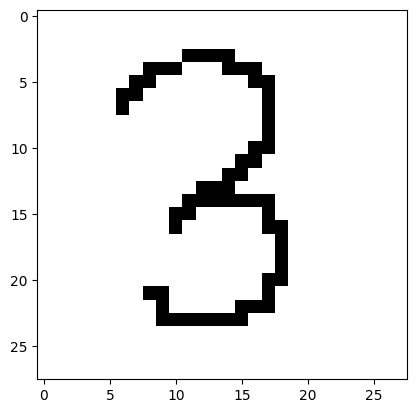

Predicted value: 1


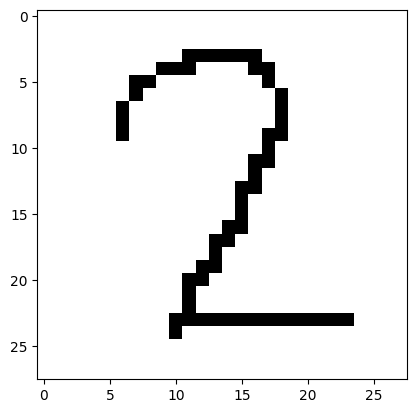

Predicted value: 6


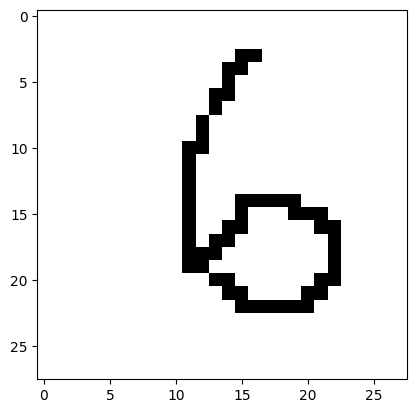

Predicted value: 5


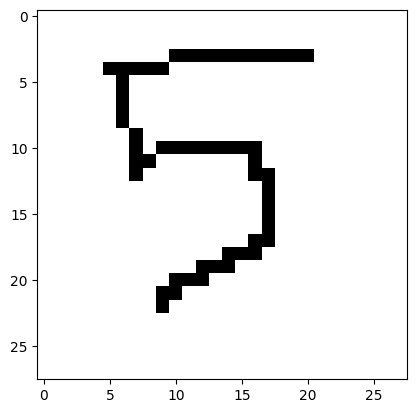

Predicted value: 3


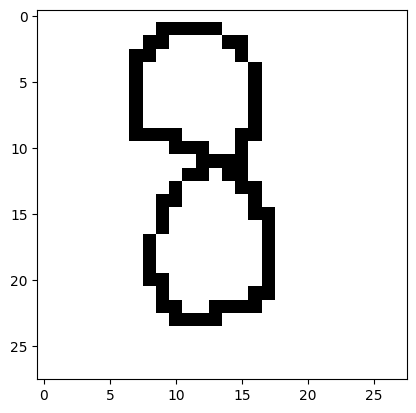

Predicted value: 2


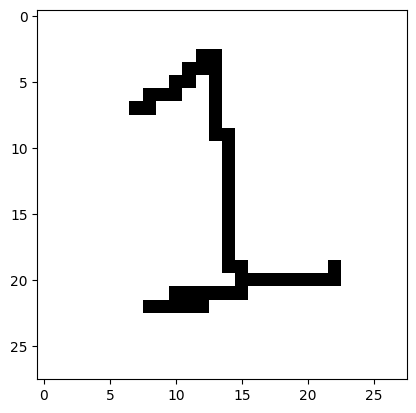

In [52]:
import matplotlib.pyplot as plt

for x in range(1,7):
    image = cv.imread(f'{x}.png')[:,:,0]
    image = np.invert(np.array(image))
    x_in = np.empty((784,1))
    for i in range(28):
        for j in range(28):
            x_in[i*28+j][0] = image[i][j]/255
    y,_,_,_,_,_ = forward_prop(x_in, w1, b1, w2, b2, w3, b3)
    print(f'Predicted value: {np.argmax(y)}')
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()

    